In [6]:
import gym

In [7]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:
obs = env.reset()

In [9]:
obs

array([-0.03010941, -0.00508483,  0.00243116, -0.04092926])

In [12]:
env.render()

NotImplementedError: abstract

In [13]:
env = gym.make('MsPacman-v0')

In [14]:
img = env.render(mode="rgb_array")

In [1]:
import gym

In [15]:
env = gym.make("MsPacman-v0")

In [16]:
obs = env.reset()

In [17]:
obs.shape

(210, 160, 3)

In [18]:
env.action_space

Discrete(9)

In [19]:
import numpy as np

mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.mean(axis=2)
    img[img==mspacman_color] = 0
    img = (img - 128) / 128 - 1
    return img.reshape(88, 80, 1)

In [20]:
img = preprocess_observation(obs)

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x10efcdef0>>
Traceback (most recent call last):
  File "/Users/takahashishota/anaconda3/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 143, in __del__
    self.close()
  File "/Users/takahashishota/anaconda3/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 62, in close
    self.window.close()
AttributeError: 'Viewer' object has no attribute 'window'


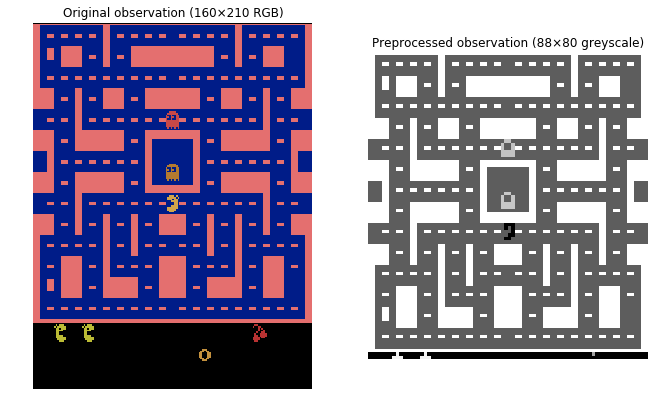

In [21]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [22]:
import tensorflow as tf

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [23]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [24]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [25]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [27]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [28]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [29]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [30]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [31]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [33]:
import os

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 11956	Training step 489/4000000 (0.0)%	Loss 0.757993	Mean Max-Q 0.043117   

KeyboardInterrupt: 

In [ ]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break